In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [4]:
diabetes_dataset = pd.read_csv('diabetes_prediction_dataset.csv')

train_dataset, test_dataset = train_test_split(diabetes_dataset, test_size=0.3, random_state=42)

# Gerar e salvar novo dataset contendo dados negativos
diabetes_negative = train_dataset.loc[diabetes_dataset['diabetes'] == 0]

# diabetes_positive = diabetes_dataset.loc[diabetes_dataset['diabetes'] == 1]

[I 2023-12-03 22:35:42,154] A new study created in memory with name: no-name-54e7ac62-dbf0-46d3-934b-70d26e51851c
[I 2023-12-03 22:35:43,272] Trial 0 finished with value: -1901863.8778730836 and parameters: {'n_components': 25, 'covariance_type': 'diag', 'init_params': 'random_from_data'}. Best is trial 0 with value: -1901863.8778730836.
[I 2023-12-03 22:35:58,955] Trial 1 finished with value: -2230051.048723342 and parameters: {'n_components': 63, 'covariance_type': 'full', 'init_params': 'k-means++'}. Best is trial 1 with value: -2230051.048723342.
[I 2023-12-03 22:36:00,409] Trial 2 finished with value: 265563.08742518205 and parameters: {'n_components': 71, 'covariance_type': 'tied', 'init_params': 'random'}. Best is trial 1 with value: -2230051.048723342.
[I 2023-12-03 22:36:16,352] Trial 3 finished with value: -2173429.398866638 and parameters: {'n_components': 49, 'covariance_type': 'full', 'init_params': 'random_from_data'}. Best is trial 1 with value: -2230051.048723342.
[I 20

Melhores hiperparâmetros encontrados: {'n_components': 100, 'covariance_type': 'diag', 'init_params': 'kmeans'}


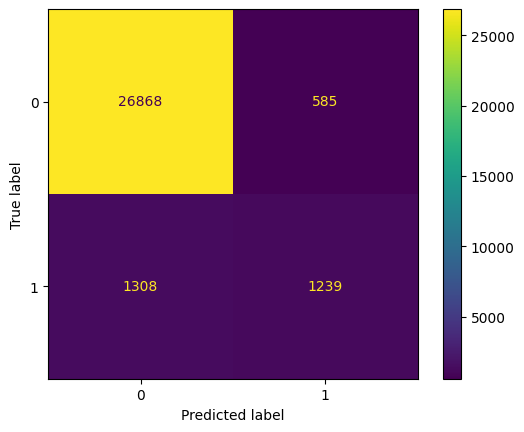

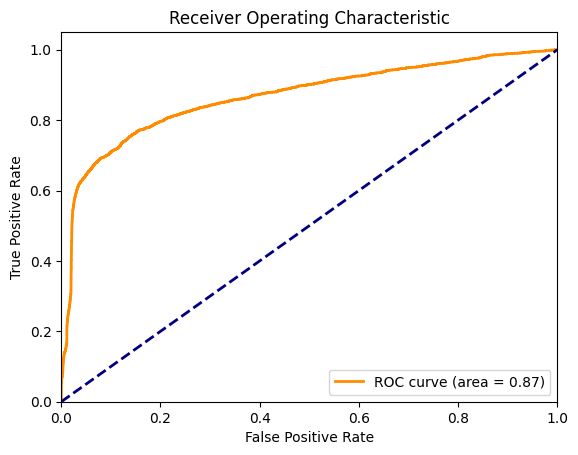

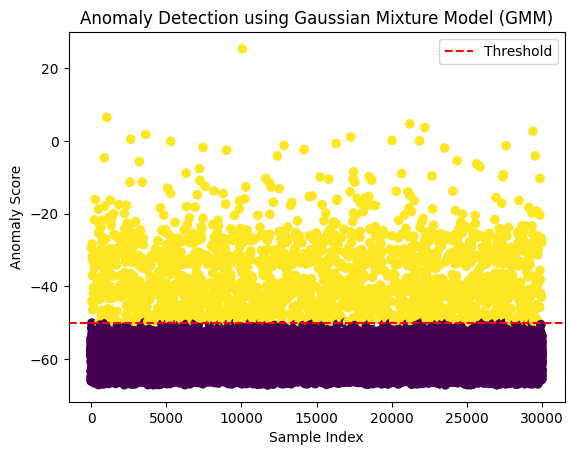

Área sob a curva ROC: 0.8663684706178276
Acurácia: 0.9369 
Revocação: 0.48645465253239106 
Precisão: 0.6792763157894737 
F1 score: 0.5669183253260123


In [6]:
X_train = diabetes_negative.drop(columns=['diabetes'])
X_test = test_dataset.drop(columns=['diabetes'])
y_test = test_dataset['diabetes']

# Codifica as colunas 'gender', 'smoking_history'
columns_to_encode = ['gender', 'smoking_history']
X_train_encoded = pd.get_dummies(X_train, columns=columns_to_encode)
X_test_encoded = pd.get_dummies(X_test, columns=columns_to_encode)

scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_encoded)

X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

X_validation, _ = train_test_split(X_train_scaled, test_size=0.7, random_state=42)

# Função objetivo para otimização bayesiana
def objective_gmm(trial):
    n_components = trial.suggest_int('n_components', 2, 100)
    covariance_type = trial.suggest_categorical('covariance_type', ['full', 'tied', 'diag', 'spherical'])
    init_params = trial.suggest_categorical('init_params', ['kmeans', 'k-means++', 'random', 'random_from_data'])

    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, init_params=init_params)
    gmm.fit(X_validation)

    # Calcula a métrica (por exemplo, AIC) - altere conforme necessário
    metric = gmm.aic(X_validation)  # Você pode usar outras métricas como BIC, log-likelihood, etc.

    return metric

# Executa a otimização bayesiana com Optuna
study = optuna.create_study(direction='minimize')  # Se estiver maximizando, use 'maximize'
study.optimize(objective_gmm, n_trials=100)  # Número de tentativas

# Obtém os melhores hiperparâmetros encontrados
best_params = study.best_params
print("Melhores hiperparâmetros encontrados:", best_params)

gmm = GaussianMixture(n_components=best_params['n_components'], random_state=42, covariance_type=best_params['covariance_type'], init_params=best_params['init_params'])
# gmm = GaussianMixture(n_components=100, random_state=42, covariance_type='diag', init_params='kmeans')
gmm.fit(X_train_scaled)

test_scores = gmm.score_samples(X_test_scaled)

# Calcule a curva ROC e a área sob a curva para cada componente
fpr, tpr, thresholds = roc_curve(y_test, -test_scores)  # Note a negação de test_scores
roc_auc = auc(fpr, tpr)

# threshold = np.percentile(-test_scores, 5)
threshold = -50
anomalies = -test_scores > threshold
y_pred = (-test_scores > threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Plote a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

plt.scatter(range(X_test_scaled.shape[0]), -test_scores, c=anomalies, cmap='viridis')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Detection using Gaussian Mixture Model (GMM)')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

print('Área sob a curva ROC:', roc_auc)
print(f"Acurácia: {accuracy} \nRevocação: {recall} \nPrecisão: {precision} \nF1 score: {f1}")
